In [6]:
import pandas as pd
import numpy as np
import os
import csv

# 1. Define File Paths

In [7]:
LANGUOID_CSV = '/Users/mehmetsundu/mysql_files/languoid.csv'
LANGUAGE_CSV = '/Users/mehmetsundu/mysql_files/language.csv'
LANGUAGES_AND_DIALECTS_GEO_CSV = '/Users/mehmetsundu/mysql_files/languages-and-dialects-geo.csv'

In [8]:
# Output directories for cleaned data
CLEANED_DATA_DIR = '/Users/mehmetsundu/mysql_files/cleaned_data'
os.makedirs(CLEANED_DATA_DIR, exist_ok=True)

# 2. Preprocess CSV Files to Standardize Quotes

In [9]:
def preprocess_csv(input_path, output_path):
    """
    Preprocesses a CSV file by standardizing quotes and escaping delimiters.
    """
    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8', newline='') as outfile:
        reader = csv.reader(infile, delimiter=',', quotechar="'", escapechar='\\')
        writer = csv.writer(outfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            writer.writerow(row)

# Preprocess each CSV file
preprocess_csv(LANGUOID_CSV, os.path.join(CLEANED_DATA_DIR, 'preprocessed_languoid.csv'))
preprocess_csv(LANGUAGE_CSV, os.path.join(CLEANED_DATA_DIR, 'preprocessed_language.csv'))
preprocess_csv(LANGUAGES_AND_DIALECTS_GEO_CSV, os.path.join(CLEANED_DATA_DIR, 'preprocessed_languages_and_dialects_geo.csv'))

print("Preprocessing of CSV files completed.")

# Update file paths to preprocessed files
PREPROCESSED_LANGUOID_CSV = os.path.join(CLEANED_DATA_DIR, 'preprocessed_languoid.csv')
PREPROCESSED_LANGUAGE_CSV = os.path.join(CLEANED_DATA_DIR, 'preprocessed_language.csv')
PREPROCESSED_LANGUAGES_AND_DIALECTS_GEO_CSV = os.path.join(CLEANED_DATA_DIR, 'preprocessed_languages_and_dialects_geo.csv')



Preprocessing of CSV files completed.


# 3. Read Preprocessed CSV Files with Enhanced Error Handling


In [ ]:
# Function to read CSV with single quote enclosure and handle newlines within fields
def read_csv_single_quote_with_logging(path, **kwargs):
    bad_lines = []

    def bad_line_handler(bad_line):
        bad_lines.append(bad_line)
        return None  # Skip the bad line

    df = pd.read_csv(
        path,
        sep=',',
        quotechar='"',              # Updated to double quotes after preprocessing
        escapechar='\\',
        encoding='utf-8',
        engine='python',
        on_bad_lines=bad_line_handler,
        **kwargs
    )
    return df, bad_lines

# a. Read preprocessed_languoid.csv
try:
    languoid_df, languoid_bad = read_csv_single_quote_with_logging(
        PREPROCESSED_LANGUOID_CSV,
        dtype={
            'id': str,
            'name': str,
            'level': str,
            'status': str,
            'family_pk': str,
            'father_pk': str,
            'hid': str,
            'jsondata': str,
            'newick': str,
            'pk': str
        },
        na_values=['', 'NULL', 'NaN']
    )
    print("Successfully loaded preprocessed_languoid.csv")
    if languoid_bad:
        print(f"Found {len(languoid_bad)} bad lines in preprocessed_languoid.csv:")
        for line in languoid_bad:
            print(line)
except Exception as e:
    print(f"Error loading preprocessed_languoid.csv: {e}")

# b. Read preprocessed_language.csv
try:
    language_df, language_bad = read_csv_single_quote_with_logging(
        PREPROCESSED_LANGUAGE_CSV,
        dtype={
            'glottocode': str,
            'Name': str,
            'iso_code': str,
            'family': str,
            'genus': str,
            'macroarea': str,
            'countrycodes': str
        },
        na_values=['', 'NULL', 'NaN']
    )
    print("Successfully loaded preprocessed_language.csv")
    if language_bad:
        print(f"Found {len(language_bad)} bad lines in preprocessed_language.csv:")
        for line in language_bad:
            print(line)
except Exception as e:
    print(f"Error loading preprocessed_language.csv: {e}")

# c. Read preprocessed_languages-and-dialects-geo.csv
try:
    languages_geo_df, languages_geo_bad = read_csv_single_quote_with_logging(
        PREPROCESSED_LANGUAGES_AND_DIALECTS_GEO_CSV,
        dtype={
            'glottocode': str,
            'name': str,
            'isocodes': str,
            'level': str,
            'macroarea': str,
            'latitude': float,
            'longitude': float
        },
        na_values=['', 'NULL', 'NaN']
    )
    print("Successfully loaded preprocessed_languages-and-dialects-geo.csv")
    if languages_geo_bad:
        print(f"Found {len(languages_geo_bad)} bad lines in preprocessed_languages-and-dialects-geo.csv:")
        for line in languages_geo_bad:
            print(line)
except Exception as e:
    print(f"Error loading preprocessed_languages-and-dialects-geo.csv: {e}")

# 4. Clean and Standardize Data


In [ ]:
# a. Clean 'status' field in languoid_df
def clean_status(status):
    if pd.isnull(status):
        return 'unknown'
    # Remove single quotes and newline characters, trim whitespace, convert to lowercase
    return status.replace("'", "").replace("\n", "").strip().lower()

languoid_df['status_cleaned'] = languoid_df['status'].apply(clean_status)

# b. Clean 'family' and 'genus' in language_df
language_df['family'] = language_df['family'].str.strip().str.lower()
language_df['genus'] = language_df['genus'].str.strip().str.lower()

# c. Clean 'name' fields by trimming whitespace
languoid_df['name'] = languoid_df['name'].str.strip()
language_df['Name'] = language_df['Name'].str.strip()
languages_geo_df['name'] = languages_geo_df['name'].str.strip()

# d. Handle missing latitude and longitude in language_df and languages_geo_df
# Already handled by na_values during reading

# e. Verify and handle duplicate Glottocodes within each dataset

# Function to check duplicates
def check_duplicates(df, column, dataset_name):
    duplicates = df[df[column].duplicated(keep=False)]
    if not duplicates.empty:
        print(f"Duplicate Glottocodes found in {dataset_name}:")
        print(duplicates[[column]].drop_duplicates())
    else:
        print(f"No duplicate Glottocodes in {dataset_name}.")

check_duplicates(languoid_df, 'id', 'preprocessed_languoid.csv')
check_duplicates(language_df, 'glottocode', 'preprocessed_language.csv')
check_duplicates(languages_geo_df, 'glottocode', 'preprocessed_languages-and-dialects-geo.csv')

# Assuming no duplicates found; if duplicates exist, decide how to handle them (e.g., keep first, aggregate)

# f. Drop duplicates if any (keeping the first occurrence)
languoid_df = languoid_df.drop_duplicates(subset='id', keep='first')
language_df = language_df.drop_duplicates(subset='glottocode', keep='first')
languages_geo_df = languages_geo_df.drop_duplicates(subset='glottocode', keep='first')


# 5. Validate Glottocode Consistency Across Datasets


In [ ]:
# a. Ensure that Glottocode in language_df exists in languoid_df
missing_in_languoid = language_df[~language_df['glottocode'].isin(languoid_df['id'])]
if not missing_in_languoid.empty:
    print("Glottocodes in language.csv not found in languoid.csv:")
    print(missing_in_languoid[['glottocode', 'Name']])
else:
    print("All Glottocodes in language.csv are present in languoid.csv.")

# b. Ensure that Glottocode in languages_geo_df exists in languoid_df
missing_in_languoid_geo = languages_geo_df[~languages_geo_df['glottocode'].isin(languoid_df['id'])]
if not missing_in_languoid_geo.empty:
    print("Glottocodes in languages-and-dialects-geo.csv not found in languoid.csv:")
    print(missing_in_languoid_geo[['glottocode', 'name']])
else:
    print("All Glottocodes in languages-and-dialects-geo.csv are present in languoid.csv.")

# 6. Merge Datasets on Glottocode


In [13]:
# a. Merge language_df with languoid_df on Glottocode
merged_df = pd.merge(
    language_df,
    languoid_df[['id', 'status_cleaned']],
    how='left',
    left_on='glottocode',
    right_on='id',
    validate='many_to_one'  # Each glottocode in language_df should map to one in languoid_df
)

# b. Merge with languages_geo_df to include geographical data
merged_df = pd.merge(
    merged_df,
    languages_geo_df[['glottocode', 'latitude', 'longitude', 'macroarea']],
    how='left',
    on='glottocode',
    suffixes=('_wals', '_geo'),
    validate='many_to_one'
)

# 7. Final Cleaning and Preparation

In [14]:
# a. Handle missing 'status_cleaned' by assigning 'unknown'
merged_df['status_cleaned'] = merged_df['status_cleaned'].fillna('unknown')

# b. Select and rename necessary columns for MySQL
final_df = merged_df.rename(columns={
    'glottocode': 'Language_ID',
    'Name': 'Language_Name',
    'iso_code': 'ISO_Code',
    'family': 'Family_Name',
    'genus': 'Genus_Name',
    'macroarea_wals': 'Macroarea_WALS',
    'macroarea_geo': 'Macroarea_Geo',
    'latitude_wals': 'Latitude_WALS',
    'longitude_wals': 'Longitude_WALS',
    'latitude_geo': 'Latitude_Geo',
    'longitude_geo': 'Longitude_Geo',
    'status_cleaned': 'Status'
})

# c. Consolidate latitude and longitude (prioritize geo data if available)
final_df['Latitude'] = final_df['Latitude_Geo'].combine_first(final_df['Latitude_WALS'])
final_df['Longitude'] = final_df['Longitude_Geo'].combine_first(final_df['Longitude_WALS'])

# d. Consolidate macroarea (prioritize geo data if available)
final_df['Macroarea'] = final_df['Macroarea_Geo'].combine_first(final_df['Macroarea_WALS'])

# e. Select relevant columns
final_df = final_df[[
    'Language_ID',
    'Language_Name',
    'ISO_Code',
    'Family_Name',
    'Genus_Name',
    'Status',
    'Macroarea',
    'Latitude',
    'Longitude',
    'countrycodes'
]]

# f. Handle missing Family or Genus names
# You may choose to fill missing families/genera with 'unknown' or drop them
final_df['Family_Name'] = final_df['Family_Name'].fillna('unknown')
final_df['Genus_Name'] = final_df['Genus_Name'].fillna('unknown')

# 8. Extract Families and Genera Tables

In [15]:
# a. Extract unique families
families_df = final_df[['Family_Name']].drop_duplicates().reset_index(drop=True)
families_df['Family_ID'] = families_df.index + 1  # Assign unique Family_ID starting from 1

# b. Extract unique genera with corresponding Family_ID
# Merge to get Family_ID for each genus
genera_df = final_df[['Genus_Name', 'Family_Name']].drop_duplicates().reset_index(drop=True)
genera_df = pd.merge(
    genera_df,
    families_df,
    on='Family_Name',
    how='left',
    validate='many_to_one'
)
genera_df = genera_df.rename(columns={'Family_ID': 'Family_ID'})
genera_df['Genus_ID'] = genera_df.index + 1  # Assign unique Genus_ID starting from 1


# 9. Assign Family_ID and Genus_ID to Languages


In [16]:
# a. Merge final_df with families_df to get Family_ID
final_df = pd.merge(
    final_df,
    families_df,
    on='Family_Name',
    how='left',
    validate='many_to_one'
)

# b. Merge with genera_df to get Genus_ID
final_df = pd.merge(
    final_df,
    genera_df[['Genus_Name', 'Genus_ID']],
    on='Genus_Name',
    how='left',
    validate='many_to_one'
)

# c. Handle missing Family_ID or Genus_ID
final_df['Family_ID'] = final_df['Family_ID'].fillna(0).astype(int)
final_df['Genus_ID'] = final_df['Genus_ID'].fillna(0).astype(int)

# 10. Export Cleaned Data to CSV for MySQL Loading

In [17]:
# a. Export Families Table
families_df.to_csv(
    os.path.join(CLEANED_DATA_DIR, 'Families.csv'),
    index=False,
    columns=['Family_ID', 'Family_Name']
)
print("Exported Families.csv")

# b. Export Genera Table
genera_export_df = genera_df[['Genus_ID', 'Genus_Name', 'Family_ID']]
genera_export_df.to_csv(
    os.path.join(CLEANED_DATA_DIR, 'Genera.csv'),
    index=False
)
print("Exported Genera.csv")

# c. Export Languages Table
languages_export_df = final_df.rename(columns={
    'countrycodes': 'Countrycodes'
})[['Language_ID', 'Language_Name', 'ISO_Code', 'Family_ID', 'Genus_ID', 'Status', 'Macroarea', 'Latitude', 'Longitude', 'Countrycodes']]

languages_export_df.to_csv(
    os.path.join(CLEANED_DATA_DIR, 'Languages.csv'),
    index=False
)
print("Exported Languages.csv")

Exported Families.csv
Exported Genera.csv
Exported Languages.csv


# 11. Summary of Cleaning Process


In [18]:
print("\nData Cleaning Process Completed Successfully!")
print(f"Cleaned data exported to directory: {CLEANED_DATA_DIR}")


Data Cleaning Process Completed Successfully!
Cleaned data exported to directory: /Users/mehmetsundu/mysql_files/cleaned_data


Index(['Family_Name', 'Genus_Name', 'Total_Languages', 'Endangered_Languages',
       'Endangerment_Rate_Percentage'],
      dtype='object')


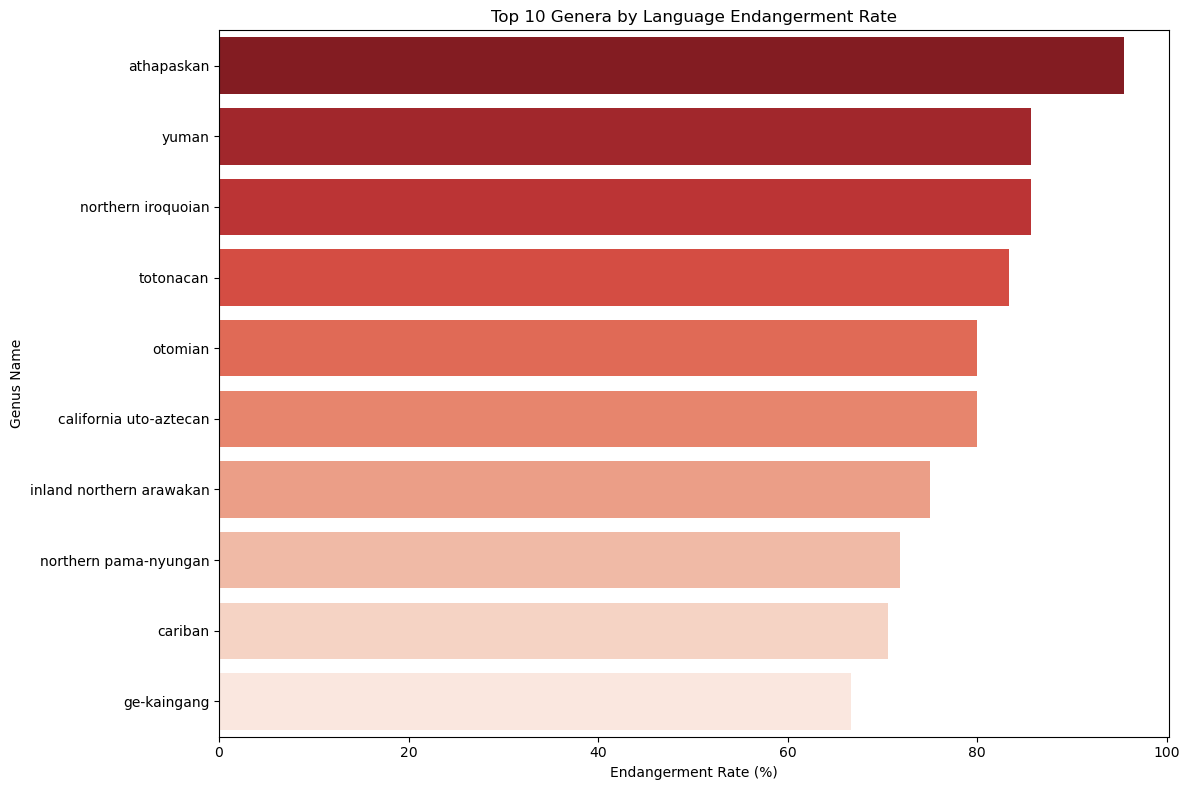

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the exported CSV
df = pd.read_csv('/Users/mehmetsundu/mysql_files/cleaned_data/endangerment_rates_per_family_genus.csv')

# Rename columns to more meaningful names
df.columns = ['Family_Name', 'Genus_Name', 'Total_Languages', 'Endangered_Languages', 'Endangerment_Rate_Percentage']

# Check the column names to ensure they match
print(df.columns)

# Create a bar chart for the top 10 genera with highest endangerment rates
top_10 = df.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Endangerment_Rate_Percentage', y='Genus_Name', data=top_10, palette='Reds_r')
plt.title('Top 10 Genera by Language Endangerment Rate')
plt.xlabel('Endangerment Rate (%)')
plt.ylabel('Genus Name')
plt.tight_layout()
plt.show()


In [33]:
column_names = [
    'Language_ID', 'Language_Name', 'Family_Name', 'Genus_Name', 
    'Status', 'Macroarea', 'Latitude', 'Longitude'
]
data = pd.read_csv('/Users/mehmetsundu/mysql_files/cleaned_data/language_endangerment_data.csv', header=None, names=column_names)


In [34]:
print(data.columns)

Index(['Language_ID', 'Language_Name', 'Family_Name', 'Genus_Name', 'Status',
       'Macroarea', 'Latitude', 'Longitude'],
      dtype='object')


In [35]:
data.columns = data.columns.str.strip()

In [36]:
# Check the exact names
print(data.columns)

Index(['Language_ID', 'Language_Name', 'Family_Name', 'Genus_Name', 'Status',
       'Macroarea', 'Latitude', 'Longitude'],
      dtype='object')


In [37]:
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')


In [39]:
import folium

# Create a base map centered at an average global location
m = folium.Map(location=[0, 0], zoom_start=2)

# Add points to the map for each language
for _, row in data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"<strong>Language:</strong> {row['Language_Name']}<br>"
            f"<strong>Family:</strong> {row['Family_Name']}<br>"
            f"<strong>Genus:</strong> {row['Genus_Name']}<br>"
            f"<strong>Status:</strong> {row['Status']}<br>"
            f"<strong>Macroarea:</strong> {row['Macroarea']}"
        ),
        icon=folium.Icon(color='red' if 'endangered' in row['Status'] else 'blue')
    ).add_to(m)

# Save the map to an HTML file
m.save('/Users/mehmetsundu/mysql_files/cleaned_data/language_endangerment_map.html')
print("Map has been saved as 'language_endangerment_map.html'")


Map has been saved as 'language_endangerment_map.html'
